In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/19CSE453/tanglish/pos/rnn"

/content/drive/MyDrive/Colab Notebooks/19CSE453/tanglish/pos/rnn


In [3]:
!ls

main.ipynb  virakesari-1.txt


In [6]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from keras.utils import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [7]:
tagset = []
tmp2 = []
with open("./virakesari-1.txt", encoding="utf-8") as f:
    for line in f:
        tmp = line.strip()
        if tmp:
            if tmp != ".\PUNCT":
                tmp = tmp.split('\\', 1)
                tmp2.append(tmp)
            else:
                tagset.append(tmp2)
                tmp2 = []

In [8]:
tagset[7]

[['எனவே', 'CCONJ'],
 ['கடந்தகாலத்தில்', 'NOUN'],
 ['எமக்கு', 'PRON'],
 ['தரப்படாமல்', 'VERB'],
 ['இருந்தவற்றை', 'ADV'],
 ['இந்த', 'DET'],
 ['வருடத்திலாவது', 'NOUN'],
 ['எமக்கு', 'PRON'],
 ['தருவதற்கு', 'NOUN'],
 ['ஆளுநர்', 'NOUN'],
 ['நடவடிக்கை', 'NOUN'],
 ['வட', 'NOUN'],
 ['மாகாண', 'NOUN'],
 ['முதலமைச்சர்', 'NOUN'],
 ['விக்கினேஸ்வரன்', 'PROPN'],
 ['கோரிக்கை', 'NOUN'],
 ['விடுத்தார்', 'VERB']]

In [10]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagset:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag

    X.append(X_sentence)
    Y.append(Y_sentence)

In [11]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))


In [12]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 6375
Vocabulary size: 18675
Total number of tags: 13


In [14]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', " ".join(X[0]), '\n')
print('sample Y: ', " ".join(Y[0]), '\n')


sample X:  இல்­லையா என்­பதை மக்கள் முன்­னி­லையில் குறிப்­பிட வேண்டும் 

sample Y:  NOUN VERB NOUN NOUN VERB VAUX 



In [15]:


# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))



Length of first input sequence  : 6
Length of first output sequence : 6


In [16]:
# encode X

word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [17]:

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [22]:
# look at first encoded data point

print("Raw data point")
print('X: ', " ".join(X[0]))
print('Y: ', " ".join(Y[0]))
print("Encoded data point")
print('X: ', X_encoded[0])
print('Y: ', Y_encoded[0])

Raw data point
X:  இல்­லையா என்­பதை மக்கள் முன்­னி­லையில் குறிப்­பிட வேண்டும்
Y:  NOUN VERB NOUN NOUN VERB VAUX
Encoded data point
X:  [2505, 481, 127, 1473, 7406, 114]
Y:  [1, 2, 1, 1, 2, 12]


In [23]:


# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))



0 sentences have disparate input-output lengths.


In [24]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 140


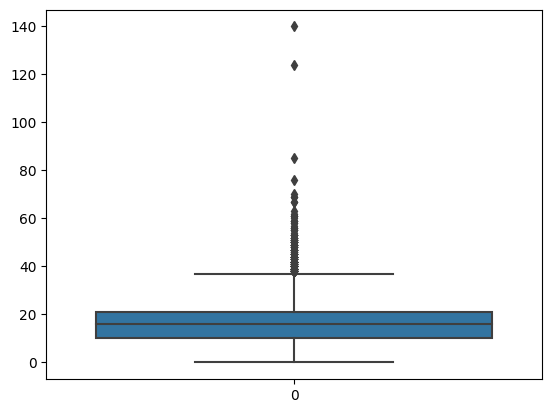

In [25]:
sns.boxplot(lengths)
plt.show()

In [26]:
MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")


In [27]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 2505  481  127 1473
 7406  114] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2
  1  1  2 12]


In [28]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

In [43]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import any2unicode

In [40]:
tagset = []
tmp2 = []
with open("./virakesari-1.txt", encoding="utf-8") as f:
    for line in f:
        tmp = line.strip()
        if tmp:
            if tmp != ".\PUNCT":
                tmp = tmp.split('\\', 1)
                tmp2.append(tmp)
            else:
                tagset.append(tmp2)
                tmp2 = []

In [49]:
data = []
for sentence in tagset:
    tmp = []
    for pair in sentence:
        tmp.append(pair[0])
    data.append(tmp)

In [50]:
data[0]

['இல்\xadலையா',
 'என்\xadபதை',
 'மக்கள்',
 'முன்\xadனி\xadலையில்',
 'குறிப்\xadபிட',
 'வேண்டும்']

In [51]:
model1 = gensim.models.Word2Vec(data, min_count = 1,
                              vector_size = 300, window = 5)

In [52]:
model1.wv['இல்\xadலையா']

array([ 1.21637085e-03,  1.56412665e-02, -2.20288732e-03,  6.29971270e-03,
        1.26747147e-03, -1.84536595e-02,  1.15102455e-02,  4.09823321e-02,
        1.68093406e-02, -2.24994402e-02, -1.07862568e-02, -1.58891957e-02,
       -5.37819322e-03, -9.78278182e-03, -2.27699243e-02, -8.85754265e-03,
        7.46545615e-03,  3.98247410e-03,  5.82212862e-03, -3.25640081e-03,
       -9.79125500e-03, -2.65049818e-03,  2.04075389e-02, -5.91270346e-03,
        4.73610777e-03,  2.49070325e-03, -3.06579135e-02,  1.58030319e-03,
       -6.64039515e-03, -1.18922973e-02,  1.17837209e-02, -1.93043821e-03,
       -1.05445320e-02, -1.11135526e-03, -9.21623409e-03,  3.84901976e-03,
       -4.60503483e-03, -1.72330942e-02, -6.62544835e-03,  4.91339108e-03,
       -2.44348636e-03,  2.90483609e-03,  4.79155965e-03, -1.65500604e-02,
        1.54858949e-02,  1.56939849e-02,  1.88931171e-03,  5.62284840e-03,
        8.79284088e-03,  1.38109205e-02,  8.05885438e-03, -8.99041072e-03,
       -4.90056910e-03,  

In [53]:
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
word2id = word_tokenizer.word_index

In [54]:
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = model1.wv[word]
    except KeyError:
        pass

In [55]:
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (18676, 300)


In [56]:
embedding_weights[word_tokenizer.word_index['இல்\xadலையா']]

array([ 1.21637085e-03,  1.56412665e-02, -2.20288732e-03,  6.29971270e-03,
        1.26747147e-03, -1.84536595e-02,  1.15102455e-02,  4.09823321e-02,
        1.68093406e-02, -2.24994402e-02, -1.07862568e-02, -1.58891957e-02,
       -5.37819322e-03, -9.78278182e-03, -2.27699243e-02, -8.85754265e-03,
        7.46545615e-03,  3.98247410e-03,  5.82212862e-03, -3.25640081e-03,
       -9.79125500e-03, -2.65049818e-03,  2.04075389e-02, -5.91270346e-03,
        4.73610777e-03,  2.49070325e-03, -3.06579135e-02,  1.58030319e-03,
       -6.64039515e-03, -1.18922973e-02,  1.17837209e-02, -1.93043821e-03,
       -1.05445320e-02, -1.11135526e-03, -9.21623409e-03,  3.84901976e-03,
       -4.60503483e-03, -1.72330942e-02, -6.62544835e-03,  4.91339108e-03,
       -2.44348636e-03,  2.90483609e-03,  4.79155965e-03, -1.65500604e-02,
        1.54858949e-02,  1.56939849e-02,  1.88931171e-03,  5.62284840e-03,
        8.79284088e-03,  1.38109205e-02,  8.05885438e-03, -8.99041072e-03,
       -4.90056910e-03,  

In [57]:
Y = to_categorical(Y)

In [58]:
print(Y.shape)

(6375, 100, 14)


In [59]:
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [60]:
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [61]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (4605, 100)
Shape of output sequences: (4605, 100, 14)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (813, 100)
Shape of output sequences: (813, 100, 14)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (957, 100)
Shape of output sequences: (957, 100, 14)


In [62]:
NUM_CLASSES = Y.shape[2]

In [63]:
rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64,
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))



# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))


In [64]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [65]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          5602800   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed (TimeDistr  (None, 100, 14)          910       
 ibuted)                                                         
                                                                 
Total params: 5,627,070
Trainable params: 24,270
Non-trainable params: 5,602,800
_________________________________________________________________


In [66]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
36/36 [==============================] - 12s 148ms/step - loss: 0.9578 - acc: 0.7852 - val_loss: 0.5266 - val_acc: 0.8621
Epoch 2/10
36/36 [==============================] - 4s 113ms/step - loss: 0.4455 - acc: 0.8909 - val_loss: 0.3937 - val_acc: 0.8985
Epoch 3/10
36/36 [==============================] - 5s 132ms/step - loss: 0.3703 - acc: 0.9027 - val_loss: 0.3562 - val_acc: 0.9024
Epoch 4/10
36/36 [==============================] - 7s 195ms/step - loss: 0.3782 - acc: 0.8994 - val_loss: 0.3790 - val_acc: 0.8973
Epoch 5/10
36/36 [==============================] - 4s 110ms/step - loss: 0.3440 - acc: 0.9069 - val_loss: 0.3342 - val_acc: 0.9064
Epoch 6/10
36/36 [==============================] - 4s 112ms/step - loss: 0.3260 - acc: 0.9090 - val_loss: 0.3229 - val_acc: 0.9084
Epoch 7/10
36/36 [==============================] - 6s 161ms/step - loss: 0.3170 - acc: 0.9092 - val_loss: 0.3146 - val_acc: 0.9084
Epoch 8/10
36/36 [==============================] - 7s 181ms/step - loss: 0

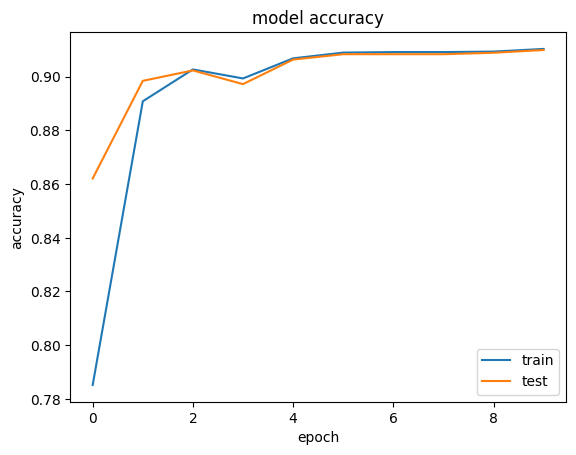

In [67]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [68]:

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64,
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [69]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [70]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          5602800   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 14)          910       
 tributed)                                                       
                                                                 
Total params: 5,627,070
Trainable params: 5,627,070
Non-trainable params: 0
_________________________________________________________________


In [71]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
36/36 [==============================] - 22s 552ms/step - loss: 0.9585 - acc: 0.7984 - val_loss: 0.4218 - val_acc: 0.9023
Epoch 2/10
36/36 [==============================] - 10s 268ms/step - loss: 0.3390 - acc: 0.9113 - val_loss: 0.2875 - val_acc: 0.9196
Epoch 3/10
36/36 [==============================] - 12s 326ms/step - loss: 0.2410 - acc: 0.9347 - val_loss: 0.2152 - val_acc: 0.9446
Epoch 4/10
36/36 [==============================] - 11s 305ms/step - loss: 0.1711 - acc: 0.9565 - val_loss: 0.1624 - val_acc: 0.9567
Epoch 5/10
36/36 [==============================] - 11s 299ms/step - loss: 0.1190 - acc: 0.9736 - val_loss: 0.1257 - val_acc: 0.9690
Epoch 6/10
36/36 [==============================] - 13s 352ms/step - loss: 0.0822 - acc: 0.9850 - val_loss: 0.1020 - val_acc: 0.9759
Epoch 7/10
36/36 [==============================] - 9s 243ms/step - loss: 0.0575 - acc: 0.9910 - val_loss: 0.0868 - val_acc: 0.9797
Epoch 8/10
36/36 [==============================] - 14s 391ms/step - l

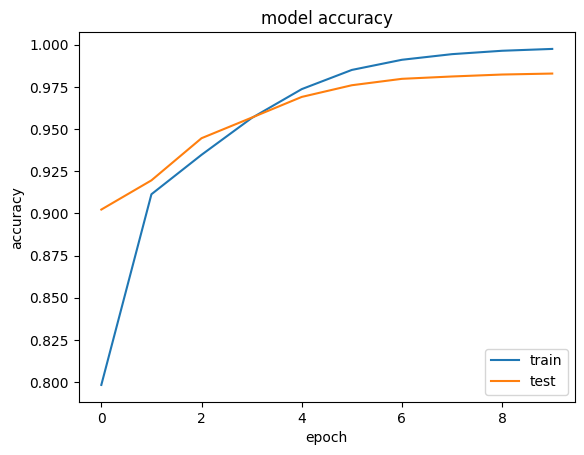

In [72]:
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [73]:
rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64,
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))


In [74]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [75]:
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          5602800   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 14)          910       
 tributed)                                                       
                                                                 
Total params: 5,627,070
Trainable params: 5,627,070
Non-trainable params: 0
_________________________________________________________________


In [76]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
36/36 [==============================] - 16s 392ms/step - loss: 0.9471 - acc: 0.8318 - val_loss: 0.3777 - val_acc: 0.9108
Epoch 2/10
36/36 [==============================] - 9s 240ms/step - loss: 0.3173 - acc: 0.9163 - val_loss: 0.2732 - val_acc: 0.9217
Epoch 3/10
36/36 [==============================] - 12s 332ms/step - loss: 0.2272 - acc: 0.9366 - val_loss: 0.1982 - val_acc: 0.9490
Epoch 4/10
36/36 [==============================] - 9s 248ms/step - loss: 0.1544 - acc: 0.9624 - val_loss: 0.1433 - val_acc: 0.9658
Epoch 5/10
36/36 [==============================] - 11s 318ms/step - loss: 0.1021 - acc: 0.9796 - val_loss: 0.1092 - val_acc: 0.9748
Epoch 6/10
36/36 [==============================] - 10s 266ms/step - loss: 0.0682 - acc: 0.9876 - val_loss: 0.0889 - val_acc: 0.9788
Epoch 7/10
36/36 [==============================] - 12s 323ms/step - loss: 0.0471 - acc: 0.9921 - val_loss: 0.0770 - val_acc: 0.9816
Epoch 8/10
36/36 [==============================] - 12s 335ms/step - lo

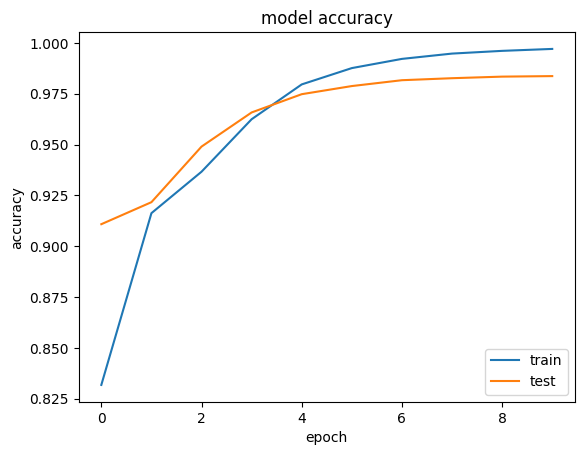

In [77]:
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [78]:

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [79]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [80]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          5602800   
                                                                 
 lstm (LSTM)                 (None, 100, 64)           93440     
                                                                 
 time_distributed_3 (TimeDis  (None, 100, 14)          910       
 tributed)                                                       
                                                                 
Total params: 5,697,150
Trainable params: 5,697,150
Non-trainable params: 0
_________________________________________________________________


In [81]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
36/36 [==============================] - 24s 565ms/step - loss: 1.1947 - acc: 0.8925 - val_loss: 0.4052 - val_acc: 0.9034
Epoch 2/10
36/36 [==============================] - 19s 519ms/step - loss: 0.3517 - acc: 0.9093 - val_loss: 0.3157 - val_acc: 0.9126
Epoch 3/10
36/36 [==============================] - 19s 525ms/step - loss: 0.2845 - acc: 0.9157 - val_loss: 0.2588 - val_acc: 0.9191
Epoch 4/10
36/36 [==============================] - 22s 625ms/step - loss: 0.2262 - acc: 0.9294 - val_loss: 0.2047 - val_acc: 0.9385
Epoch 5/10
36/36 [==============================] - 19s 523ms/step - loss: 0.1744 - acc: 0.9480 - val_loss: 0.1620 - val_acc: 0.9537
Epoch 6/10
36/36 [==============================] - 19s 533ms/step - loss: 0.1325 - acc: 0.9640 - val_loss: 0.1304 - val_acc: 0.9680
Epoch 7/10
36/36 [==============================] - 19s 527ms/step - loss: 0.0996 - acc: 0.9777 - val_loss: 0.1059 - val_acc: 0.9741
Epoch 8/10
36/36 [==============================] - 18s 504ms/step - 

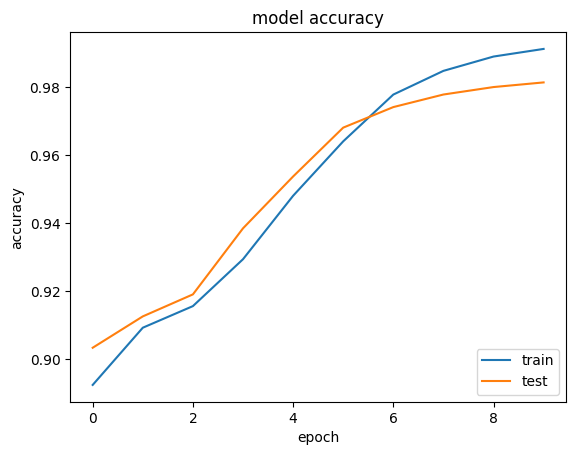

In [82]:
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [83]:

gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [84]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [85]:
gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          5602800   
                                                                 
 gru (GRU)                   (None, 100, 64)           70272     
                                                                 
 time_distributed_4 (TimeDis  (None, 100, 14)          910       
 tributed)                                                       
                                                                 
Total params: 5,673,982
Trainable params: 5,673,982
Non-trainable params: 0
_________________________________________________________________


In [86]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
36/36 [==============================] - 27s 499ms/step - loss: 1.2811 - acc: 0.9016 - val_loss: 0.3655 - val_acc: 0.9046
Epoch 2/10
36/36 [==============================] - 16s 435ms/step - loss: 0.2997 - acc: 0.9130 - val_loss: 0.2564 - val_acc: 0.9227
Epoch 3/10
36/36 [==============================] - 16s 451ms/step - loss: 0.2183 - acc: 0.9342 - val_loss: 0.1902 - val_acc: 0.9440
Epoch 4/10
36/36 [==============================] - 17s 457ms/step - loss: 0.1526 - acc: 0.9573 - val_loss: 0.1353 - val_acc: 0.9656
Epoch 5/10
36/36 [==============================] - 17s 468ms/step - loss: 0.1008 - acc: 0.9754 - val_loss: 0.1005 - val_acc: 0.9755
Epoch 6/10
36/36 [==============================] - 18s 507ms/step - loss: 0.0667 - acc: 0.9871 - val_loss: 0.0810 - val_acc: 0.9795
Epoch 7/10
36/36 [==============================] - 17s 488ms/step - loss: 0.0459 - acc: 0.9911 - val_loss: 0.0701 - val_acc: 0.9816
Epoch 8/10
36/36 [==============================] - 17s 489ms/step - 

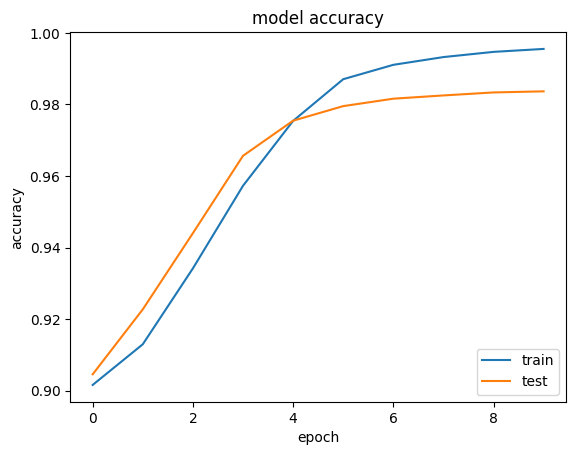

In [87]:
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [88]:
bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [89]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [90]:
bidirect_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          5602800   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         186880    
 l)                                                              
                                                                 
 time_distributed_5 (TimeDis  (None, 100, 14)          1806      
 tributed)                                                       
                                                                 
Total params: 5,791,486
Trainable params: 5,791,486
Non-trainable params: 0
_________________________________________________________________


In [91]:


bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))



Epoch 1/10
36/36 [==============================] - 41s 955ms/step - loss: 1.0488 - acc: 0.8744 - val_loss: 0.3095 - val_acc: 0.9115
Epoch 2/10
36/36 [==============================] - 35s 952ms/step - loss: 0.2789 - acc: 0.9149 - val_loss: 0.2564 - val_acc: 0.9183
Epoch 3/10
36/36 [==============================] - 36s 1s/step - loss: 0.2312 - acc: 0.9257 - val_loss: 0.2080 - val_acc: 0.9342
Epoch 4/10
36/36 [==============================] - 35s 975ms/step - loss: 0.1776 - acc: 0.9482 - val_loss: 0.1559 - val_acc: 0.9586
Epoch 5/10
36/36 [==============================] - 30s 847ms/step - loss: 0.1263 - acc: 0.9678 - val_loss: 0.1158 - val_acc: 0.9701
Epoch 6/10
36/36 [==============================] - 32s 888ms/step - loss: 0.0859 - acc: 0.9805 - val_loss: 0.0884 - val_acc: 0.9772
Epoch 7/10
36/36 [==============================] - 33s 937ms/step - loss: 0.0577 - acc: 0.9879 - val_loss: 0.0728 - val_acc: 0.9805
Epoch 8/10
36/36 [==============================] - 33s 924ms/step - los

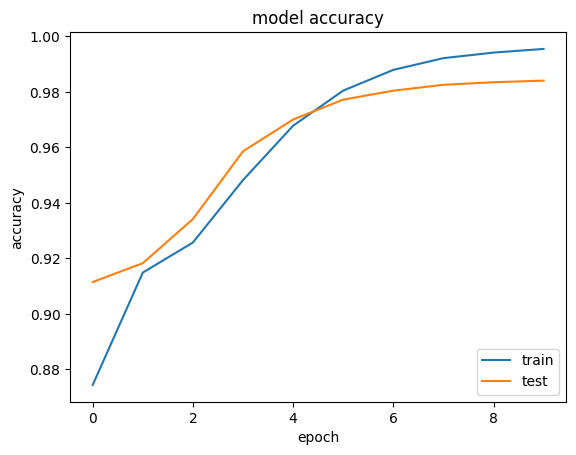

In [92]:
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()


In [93]:


loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))



30/30 [==============================] - 1s 34ms/step - loss: 0.0595 - acc: 0.9842
Loss: 0.059546925127506256,
Accuracy: 0.9842110872268677


In [94]:
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

30/30 [==============================] - 3s 114ms/step - loss: 0.0669 - acc: 0.9824
Loss: 0.06690041720867157,
Accuracy: 0.9823929071426392


In [95]:
loss, accuracy = gru_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

30/30 [==============================] - 2s 75ms/step - loss: 0.0535 - acc: 0.9844
Loss: 0.053549569100141525,
Accuracy: 0.9844096302986145


In [96]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

30/30 [==============================] - 3s 116ms/step - loss: 0.0511 - acc: 0.9851
Loss: 0.051119670271873474,
Accuracy: 0.9850574731826782


In [102]:
rnn_model.save("rnn_model")

In [103]:
model1.save("word2vec_model")